# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [317]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.stats import norm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle

from itertools import combinations_with_replacement, combinations
import pickle

# Set random seed
np.random.seed(42)


# 1. Importing the QM7 Dataset

In [318]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())


dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [319]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7["R"].shape)
display(qm7["R"][0])


(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [320]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H) 1
# 6 == carbon (C) 4
# 7 == nitrogen (N) 3
# 8 == oxygen (O) 2
# 16 == sulfur (S) 6
display(qm7["Z"].shape)
display(qm7["Z"][0])
atoms = ["H", "C", "N", "O", "S"]


(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

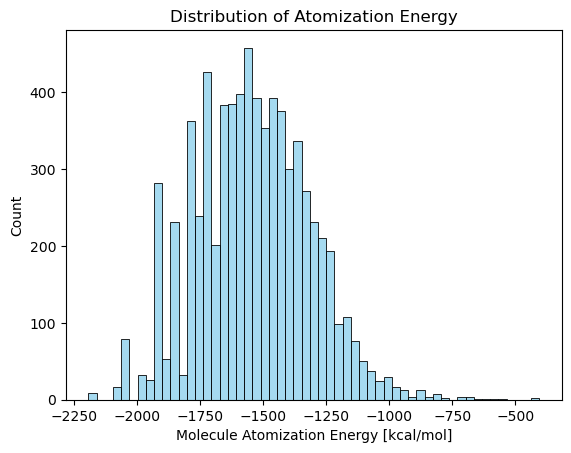

In [321]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7["T"].shape)
display(qm7["T"][0, 0])

g = sns.histplot(qm7["T"][0], color="skyblue")
g.set_xlabel("Molecule Atomization Energy [kcal/mol]")
plt.title("Distribution of Atomization Energy")
plt.show()


#### Investigate distribution of intra-molecule euclidean distances of atoms by atom types

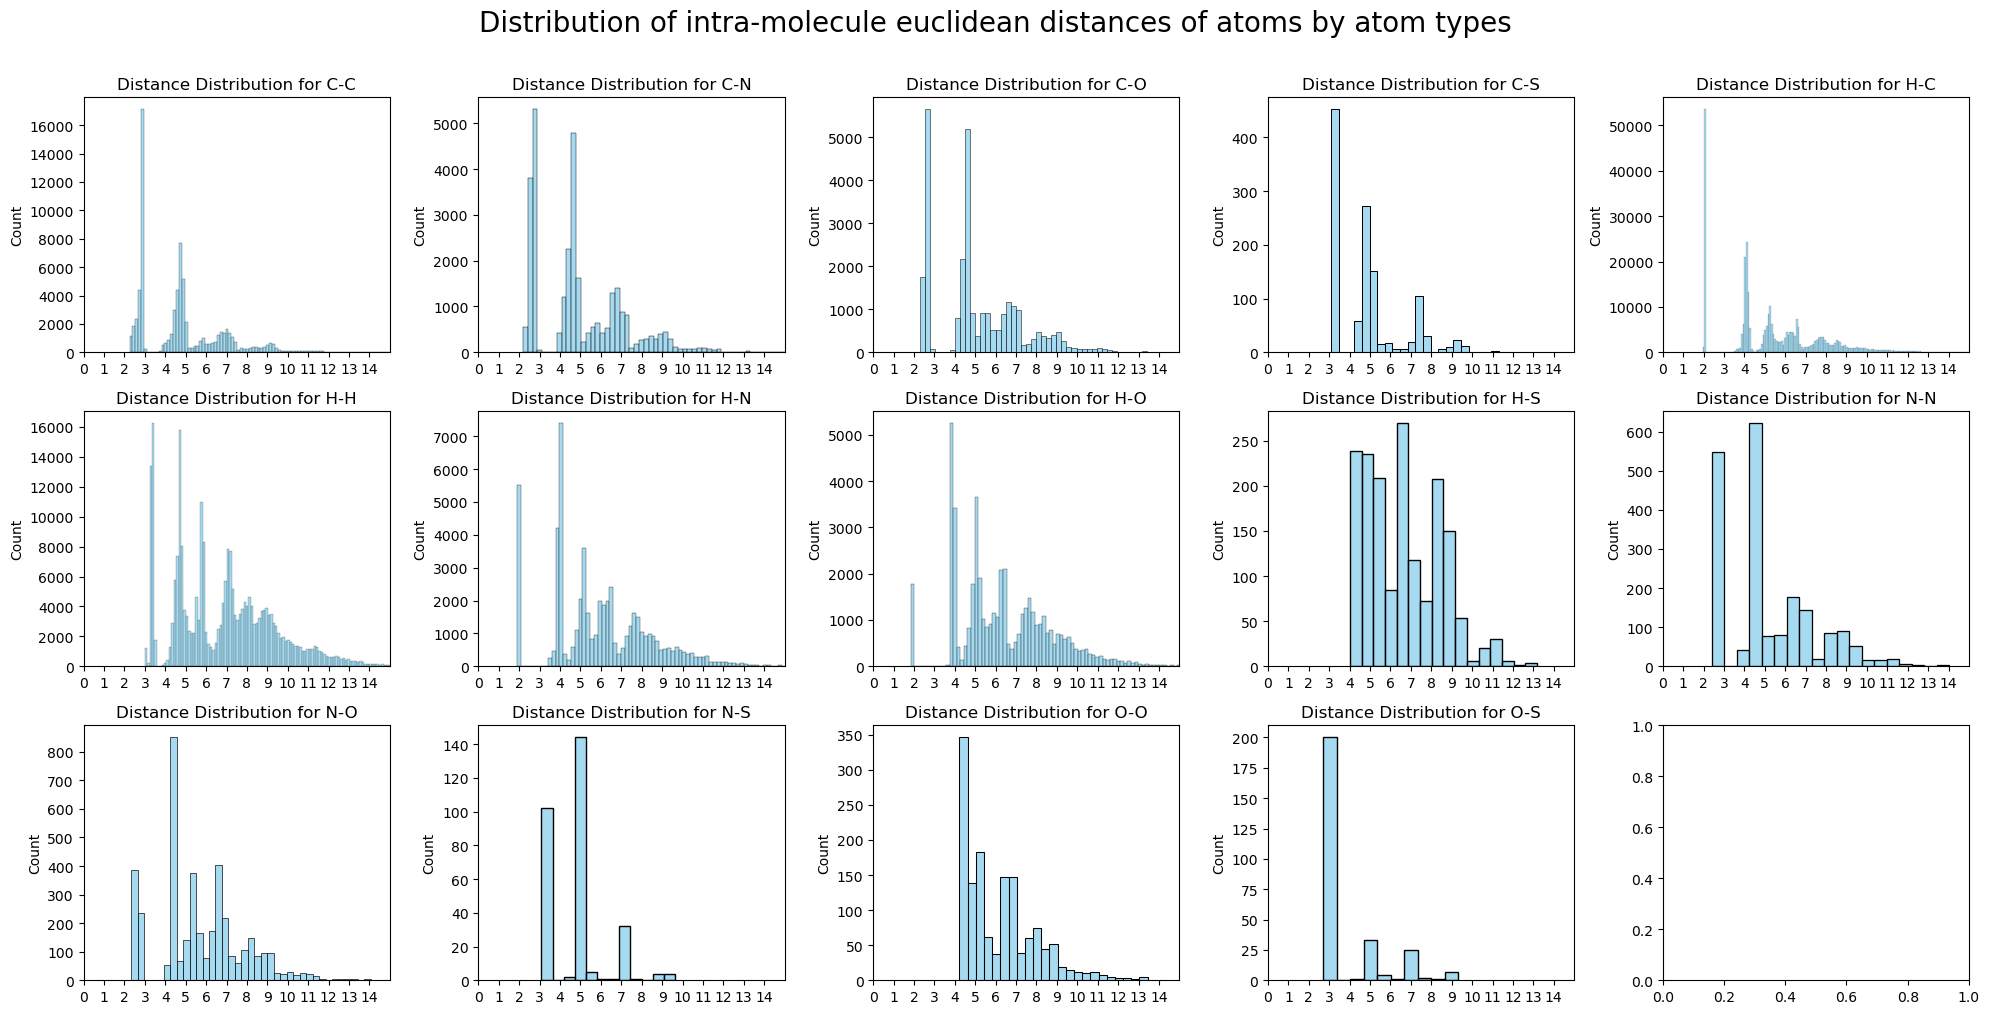

In [322]:
pdist_all = []
types_all = []
sym_to_string = {1: "H", 6: "C", 7: "N", 8: "O", 16: "S"}

for i in range(len(qm7["R"])):
    mol = qm7["R"][i]
    sym = qm7["Z"][i]

    # get atoms and remove empty ones
    sym = sym[sym > 0]
    mol = mol[: len(sym)]

    # get distances
    pdist_all.append(pdist(mol, metric="euclidean"))

    # get types of distances
    mask = np.vstack(np.triu_indices(len(mol), 1)).T
    types = np.vstack((sym[mask[:, 0]], sym[mask[:, 1]])).astype(int).T
    types = np.sort(types, axis=1)
    types_all.append(types)

pdist_all = np.concatenate(pdist_all)
types_all = np.array([sym_to_string[x[0]] + "-" + sym_to_string[x[1]] for x in np.concatenate(types_all)])

# for each type in types_all plot the histogram of pdist_all as a grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
fig.suptitle("Distribution of intra-molecule euclidean distances of atoms by atom types", fontsize=20, y=1.01)

for i, t in enumerate(np.unique(types_all)):
    sns.histplot(pdist_all[types_all == t], color="skyblue", ax=axes[i])
    axes[i].set_title(f"Distance Distribution for {t}")
    axes[i].set_xlim(0, 15)
    axes[i].set_xticks(np.arange(0, 15, 1))

plt.tight_layout()


The minimal atom distances with a spike in the count are between 2 and 3. 

With no background knowledge it's hard to judge where the actual bonds are - probably it's also atom type related. We will continue to use a threshold for the bonds of 3.

# 1.1 Visualizing Molecules

### "Quick and dirty approach"

- plot xy-coordinates of atoms, discard z-coordinate
- plot bond if euclidean distance between two point is smaller than fixed threshold

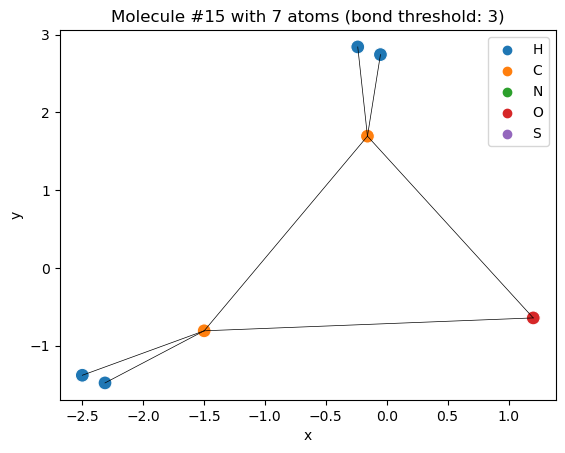

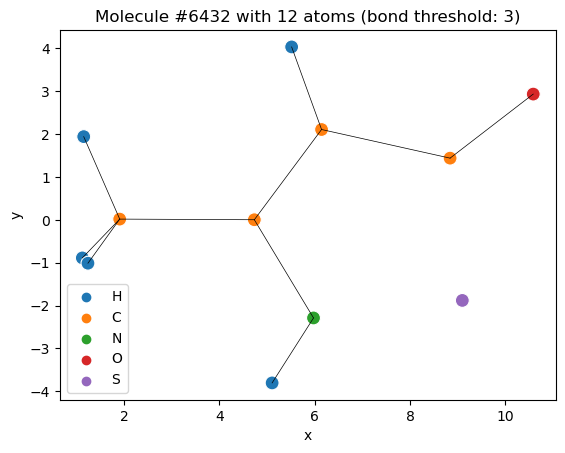

In [323]:
thresh = 3


def plot_mol(nr, thresh):
    mol = qm7["R"][nr]
    sym = qm7["Z"][nr]

    # get atoms and remove empty ones
    sym = sym[sym > 0]
    mol = mol[: len(sym)]

    sns.scatterplot(
        x=mol[:, 0],
        y=mol[:, 1],
        hue=[sym_to_string[int(i)] for i in sym],
        hue_order=sym_to_string.values(),
        marker="o",
        s=100,
    )

    # generate and plot bonds
    mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
    bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

    for i in range(len(bonds)):
        plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="black", linewidth=0.5)

    plt.title(f"Molecule #{nr} with {len(sym)} atoms (bond threshold: {thresh})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


plot_mol(15, thresh)
plot_mol(6432, thresh)


Observation: In this 2-D visualisation we chose a fixed threshold of 3. This works well enough for many bonds, but not for all of them. Different atoms have different bond lengths: as can be seen in this particular example, one atom is further away from the others. In addition to that, some atoms have multiple bonds between the same atoms (e.g. double, tripple, etc.) which is not expressed in the visualisation.

For Molecule #6432 the Sulfur Atom might be connected with the Nitrogen Atom. In the histograms above we see that N-S connections are at least slightly longer than 3, therefor we miss the bond here.

### Atomic Simulation Environment
To get a more sophisticated 3D-visualization we make use of some other libraries.

In [324]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick()  # how to specify bonds?
view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly


NGLWidget()

# 2. Simple atom-based Data Representation

#### We first decomposed the molecules into individual elements - atoms - and saved a representation of each molecule as an array with the counts of each atom type. 

#### The simple representation just counts the number of different atoms which results in a vector like [#H, #C, #N, #O, #S] per molecule.

In [325]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum up to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


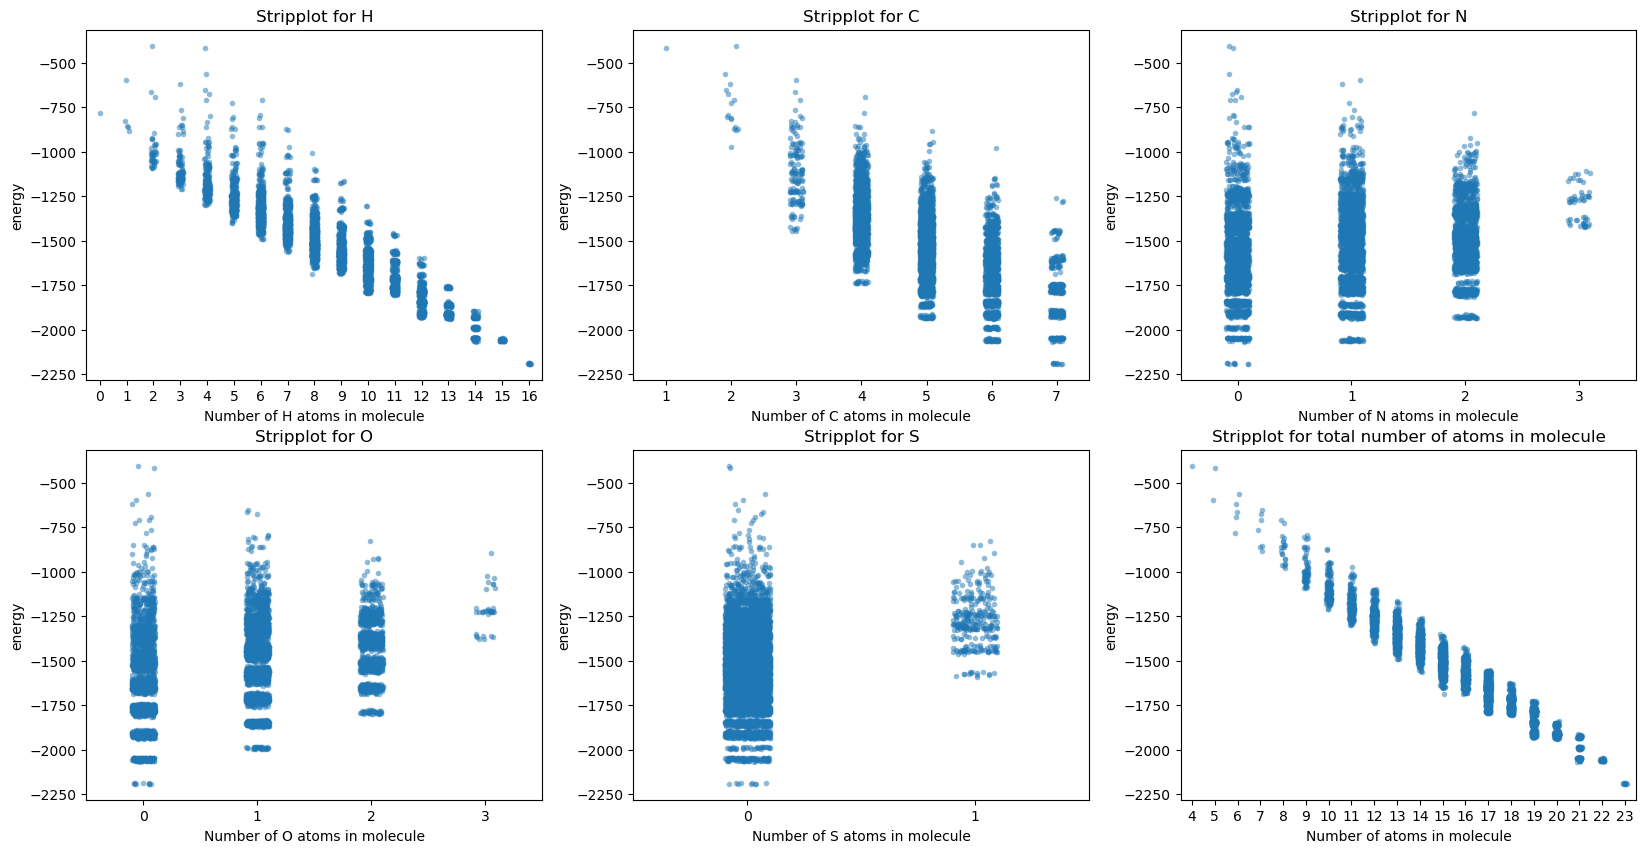

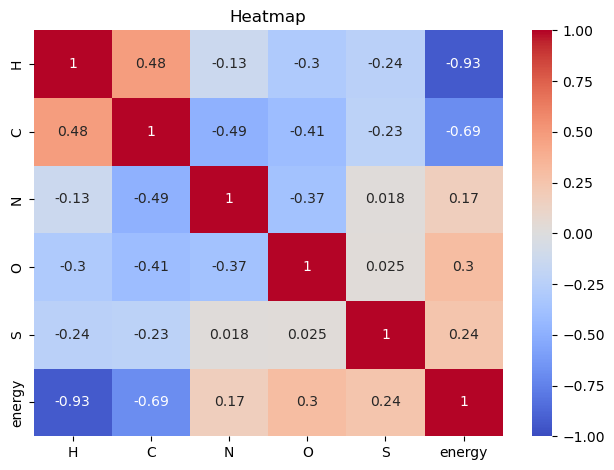

In [326]:
df = pd.DataFrame(x, columns=["H", "C", "N", "O", "S"])
df["energy"] = np.reshape(qm7["T"][0], (-1, 1))

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

# stripplots
for i in range(5):
    sns.stripplot(data=df, x=df.columns[i], y="energy", ax=axes[i], size=4, alpha=0.5)
    axes[i].set_title(f"Stripplot for {df.columns[i]}")
    axes[i].set_xlabel(f"Number of {df.columns[i]} atoms in molecule")


sns.stripplot(x=x.sum(axis=1), y=df['energy'], size=4, alpha=0.5, ax=axes[5])
plt.title("Stripplot for total number of atoms in molecule")
plt.xlabel("Number of atoms in molecule")
plt.show()

# heatmap
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Heatmap")
plt.tight_layout()


Observation: The stripplots and the correlation matrix show no concerning sign of multicollinearity - the predictor variables are not highly correlated with one another, at most carbon and nitrogen (corr = 0.48).

We can also see a strong linear relationship between the atomisation energy and the number of hydrogen atoms (corr = -0.93) as well as the number of carbon atoms (corr = -0.69) in a molecule. Meaning molecules with more hydrogen and carbon atoms tend to have a higher negative atomisation energy. This corresponds to the overall trend of molecules with more atoms tend to have higher negative energy - see last stripplot.

Interestingly the correlation for the N, O and S atoms is slow but positive, meaning that here more atoms results in the molecule having less negative atomisation energy.


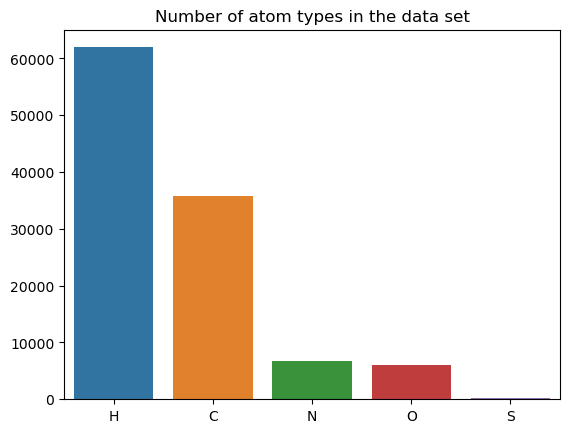

In [327]:
g = sns.barplot(x=atoms, y=np.sum(x, axis=0))
g.set_title("Number of atom types in the data set")
plt.show()


Observation: It is worth noting that hydrogen and carbon are the most common atoms in the data set.

# 2.1 ML Model: Ridge Regression

#### We then split the data into train and test subsets and centered numbers of the atoms in the molecules.

In [328]:
def split_and_center(X, y, test_size, shuffle=True):
    # split train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)

    # center data and target
    X_train_mean = np.mean(X_train, axis=0)
    y_train_mean = np.mean(y_train)

    X_train = X_train - X_train_mean
    X_test = X_test - X_train_mean

    y_train = y_train - y_train_mean
    y_test = y_test - y_train_mean

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_and_center(x, qm7["T"][0], test_size=0.3)

print("Mean of test data:")
print("X_train:", np.mean(X_test, axis=0))
print("y_train:", np.mean(y_test))


Mean of test data:
X_train: [ 0.09501032  0.01342623 -0.00263442 -0.01250435 -0.00473185]
y_train: -6.431752


#### In order to tune the regularisation parameter alpha for the Ridge regression model, we performed a grid search on the training data.

In [329]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)

search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"),  # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)

results = search.fit(X_train, y_train)


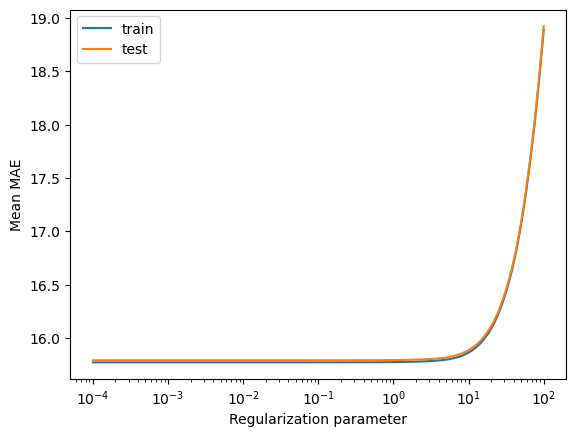

In [330]:
ax = sns.lineplot(x=alpha_values, y=-results.cv_results_["mean_train_score"], label="train")
ax = sns.lineplot(x=alpha_values, y=-results.cv_results_["mean_test_score"], label="test")
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean MAE")
plt.legend(loc="upper left")
plt.show()


#### Observation: Low regualarisation parameter achieves the lowest MAE.

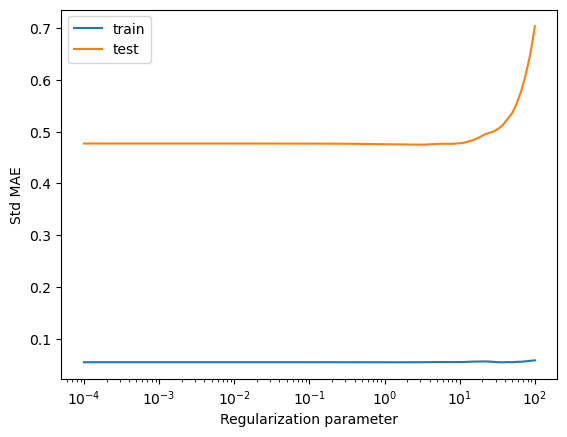

In [331]:
ax = sns.lineplot(x=alpha_values, y=results.cv_results_["std_train_score"], label="train")
ax = sns.lineplot(x=alpha_values, y=results.cv_results_["std_test_score"], label="test")
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Std MAE")
plt.legend(loc="upper left")
plt.show()


#### Observation: The standard deviation of the absolute error is very low and stable for low regualarisation parameter.

#### We plotted the regression model using the very low regularisation parameter (alpha= 0.0001) which resulted in our parameter tuning.

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


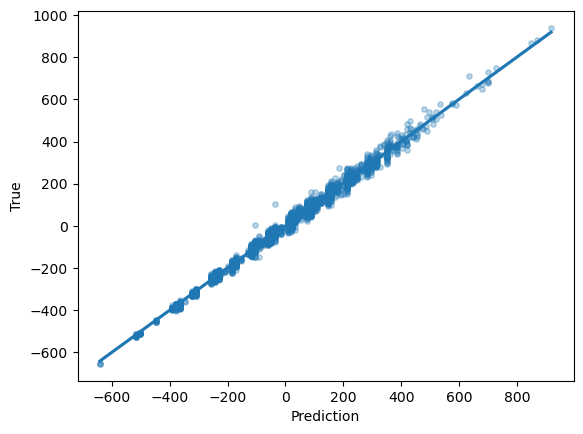

In [332]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test, scatter_kws={'s': 15, 'alpha': 0.3})

g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()


#### Since the regularisation parameter is so small we compared the results with performing a multiple linear regression without regularisation.

R2: 0.992
MAE: 15.461
MSE: 403.582


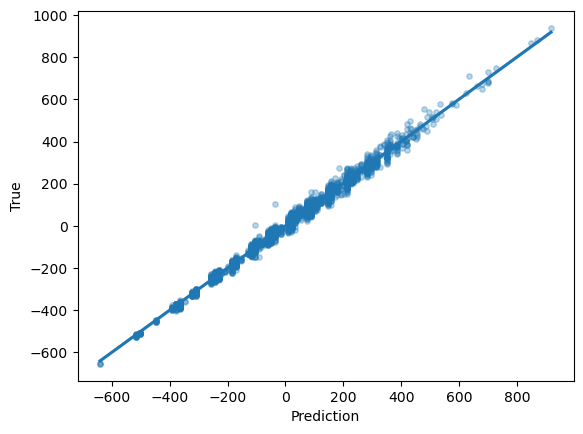

In [333]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred_lr):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr):.3f}")

g = sns.regplot(x=y_pred_lr, y=y_test, scatter_kws={'s': 15, 'alpha': 0.3})
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()


Observations:
The explained variance and error scores for these two regression models are identical. This is due to the fact that in the Ridge regression the penalty parameter is effectively 0, basically resulting in unpenalised linear regression model. Taken together with the tendency for the Ridge model to perform increasingly worse with higher regularisation term, we conclude that the Ridge regression introduces a non-beneficial bias. The possible reduction of the variance of the estimator does not seem to recuperate/improve the overall performance.
We can attribute this to the fact that we did not observe high multicolinearity in the data. In the absence of multicolinearity, linear regression tends to perform equally well or even better than Ridge regression. Ridge Regression, on the other hand, can come in hand in the case of a high number of included covariates.

We also observed that the explained variance is very high, even when fitting the regression to a low number of data points. This, too, points to a strong linear relationship between the independent and dependent variables. We observed that the most common atoms in the data, hydrogen and carbon, had a high linear relationship with the criterion. We therefore conclude that the underlying relationship in the data is highly linear.

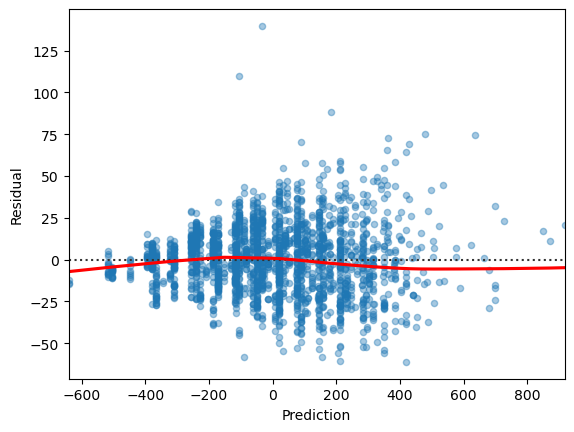

In [334]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"), scatter_kws={'s': 20, 'alpha': 0.4})
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()


Observation: The LOWESS curve, even if not completely straight, is not showing a strong trend in the residual plot. However, there is more variance in the residuals of the positive predictions. This indicares heteroscedasticity in the data (the STDs of a predicted variable, monitored over different values of independent variables, are non-constant).
This might point to biased standard errors, but should not affect the estimation of the regression coefficients, which explain 99.2 % of the variance in atomisation energy given our data set.

### Visualization for intuition: Impact of penalization on weights

In [335]:
ridge_ = Ridge()

weights_ = []
scores_ = []
for alpha in alpha_values:
    grid_ = dict(alpha=[alpha])
    search_ = GridSearchCV(
        ridge_, grid_, scoring=("neg_mean_squared_error"), cv=10, n_jobs=-1, refit="neg_mean_squared_error"
    )
    results_ = search_.fit(X_train, y_train)
    weights_ += [results_.best_estimator_.coef_]
    scores_ += [results_.best_score_]

weights_ = np.array(weights_)


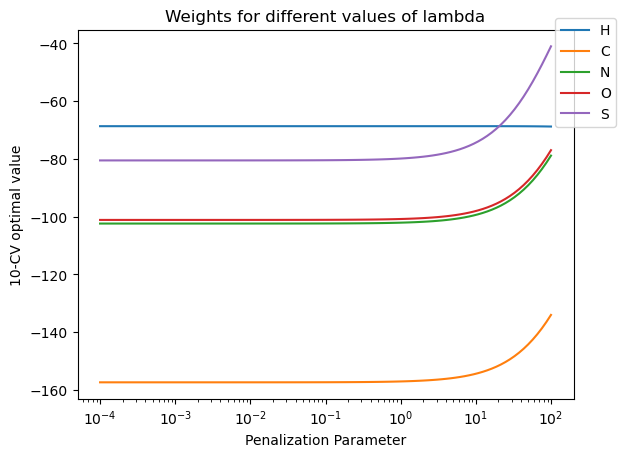

In [336]:
plt.plot(alpha_values, weights_)
plt.legend(atoms, bbox_to_anchor=(1.1, 1.05))
plt.xscale("log")
plt.title("Weights for different values of lambda")
plt.ylabel("10-CV optimal value")
plt.xlabel("Penalization Parameter")
plt.show()


Intuitively, we can see how the penalization works. Ridge introduces a shrinkage towards 0 with an increasing value of the penalization paramter. This leads to an introduced bias which possibely can reduce the estimators performance (i.e. MSE) by reducing the variance of the estimator.

# 2.2 Explanations: Simple atom-based Representation

Fitting our best found model, we get the following MAE and weights for the different atom types:

In [337]:
print(f"Best performing regularization parameter: {results.best_params_}")
print(f"MAE on validation set: {mean_absolute_error(y_test, search.best_estimator_.predict(X_test)):.3f} kcal/mol")
print("Weights Ri for H, C, N, O, S:", search.best_estimator_.coef_)


Best performing regularization parameter: {'alpha': 0.0001}
MAE on validation set: 15.461 kcal/mol
Weights Ri for H, C, N, O, S: [ -68.68727583 -157.410442   -102.41624528 -101.15629173  -80.54594189]


In the following, we will compare our gained insights with existing chemical knowledge and literature. 

Recap: As stated in the exercise, The atomization energy of a molecule is the energy generated by dissociating all atoms from the molecule, i.e. moving atoms far apart so that the bonds between atoms are broken. Because it consumes energy to break these bonds, the atomization energy is typically a negative quantity. 

The atomization energy is a complex measure influenced by a variety of factors such as the incorporated bond strengths & lengths, molecular size, bond types, electronic configurations, intermolecular interactions and the molecular geometry. Related measures are the ionisation energy or electron affinity. 

For the sake of simplicity, one can make use of the additivity property of the atomization energy of a molecule to get an estimate, i.e.  add up the energy needed to break up the atom pairs within a molecule [cf](https://www.spektrum.de/lexikon/chemie/bindungsenergie/1112). Usefully, there are several tables of empirically determined values for different pairs of atoms. To double check our estimates, we will make use of the one found in [Neufingerl: Chemie 1 - Allgemeine und anorganische Chemie, Jugend & Volk, Wien 2006; ISBN 978-3-7100-1184-9. S. 47]. 

The bounding energy of pairs of atoms depend on the bond length, the polarity of the bond and the type of the bond (simple, double, triple,  …). The more bonds are prevalent within a pair of atoms, the harder it is to separate them. In the table below, if there are multiple values given it indicates the energy needed for different types of bonds. For further calculations, the equally weighted average is taken since we have no further knowledge in the dataset about the bond types given. It is important to note that this approach serves as a simplified orientation.

In [338]:
H = [436, 413, 391, 463, 367]
C = [np.nan, (348 + 614 + 839) / 3, (305 + 615 + 891) / 3, (358 + 745) / 2, (272 + 536) / 2]
N = [np.nan, np.nan, (163 + 418 + 945) / 3, (201 + 607) / 2, 225]
O = [np.nan, np.nan, np.nan, (146 + 498) / 2, 420]  # last entry: bond-type = double
S = [np.nan, np.nan, np.nan, np.nan, 255]

binding_energy_pairs = np.array([H, C, N, O, S])
print("Binding Energy table; order: (H,C,N,O,S):\n")
print(binding_energy_pairs)
mean_binding_energies = np.nanmean(binding_energy_pairs, axis=1)
mean_binding_energies *= 0.239  # convert kJ to kcal


Binding Energy table; order: (H,C,N,O,S):

[[436.         413.         391.         463.         367.        ]
 [         nan 600.33333333 603.66666667 551.5        404.        ]
 [         nan          nan 508.66666667 404.         225.        ]
 [         nan          nan          nan 322.         420.        ]
 [         nan          nan          nan          nan 255.        ]]


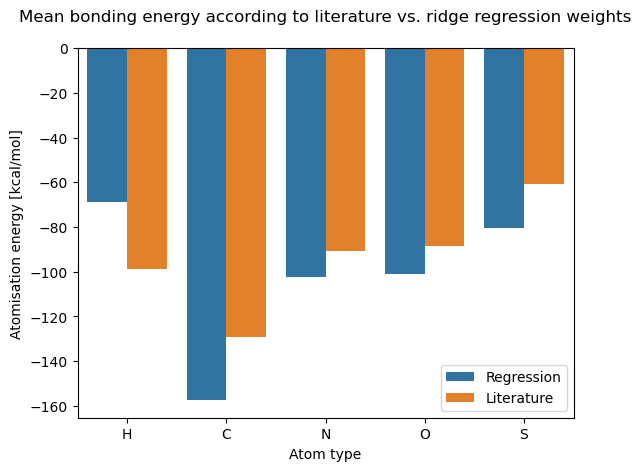

In [339]:
g = sns.barplot(
    y=np.concatenate((search.best_estimator_.coef_, -mean_binding_energies), axis=0),
    x=atoms * 2,
    hue=[*["Regression"] * 5, *["Literature"] * 5]
)
g.set_ylabel("Atomisation energy [kcal/mol]")
g.set_xlabel("Atom type")
plt.title("Mean bonding energy according to literature vs. ridge regression weights", y=1.05)
plt.show()


Comparing our results with the above-described literature, we can see that our results nearly perfectly match the findings. This is true for the ordering as well as the magnitudes of the atom influences. The only exception here is the hydrogen atom which’s impact is overestimated. Also, the Carbon impact is a little overestimated as well. However, as emphasized we are dealing with simplified approaches and differences may reasonably occur. One possible reason for this might be the pairwise discoverd correlations among H, C and the target variable. 

Overall, the results seem surprisingly satisfying!

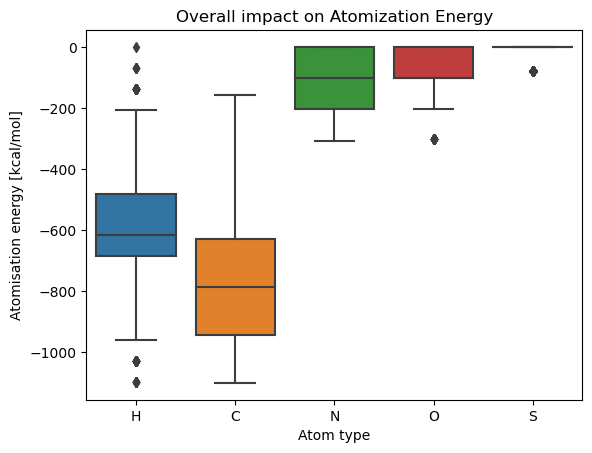

In [340]:
g = sns.boxplot(x * search.best_estimator_.coef_)
g.set_title("Overall impact on Atomization Energy")
g.set_ylabel("Atomisation energy [kcal/mol]")
g.set_xlabel("Atom type")
g.set_xticklabels(atoms)
plt.show()


# 3. Pairs-of-atoms-based Data Representation

To take the mutual distances between atoms into consideration, we decomposed each molecule into its set of pairs of atoms.
To do that, we generated a one-hot encoding of distances by binning them into multiple intervals.
We inspected tables with lengths of different atom bonds, such as found here: http://www.pathwaystochemistry.com/wp-content/uploads/BondLengths.jpg. Based on this information, we assume that the shortest bond given our atom pairs must be HH with 1.4 a.u. and the longest - SO with 5.0 a.u. We therefore set the range of distances to (1.3, 5.1) in this data representation.

To avoid introducing unnatural discontinuities into the model, we enabled not only a hard indicator function, but also a soft indicator function (Gaussian function with mean at the center of the interval and fixed variance).

In [341]:
# create dictionary to translate atom combinations to number between 0 and 14
d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

# add inverse tuples pointing to same number
inv = {}
for c in d:
    inv[c[1], c[0]] = d[c]

# merge dictionaries
d = d | inv
del inv


In [342]:
# prepare arrays with the distances and the types of all pairs
# this represation is used to efficiently generate the representations later
N_COMB = 824783
pair_dist = np.zeros(N_COMB)  # all distances
pair_type = np.zeros(N_COMB).astype(int)  # all types
mol_split = np.zeros(7165 + 1).astype(int)  # indices where to split the array to get the molecules
pair_idx = 0

for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")
    comb = [*combinations(sym, r=2)]
    n_combs = len(comb)

    pair_dist[pair_idx : pair_idx + n_combs] = dist
    pair_type[pair_idx : pair_idx + n_combs] = [d[x] for x in comb]

    mol_split[i] = pair_idx
    pair_idx += n_combs

mol_split[-1] = N_COMB


In [343]:
def generate_representaions(THETA_1, THETA_M, STD, M, soft=True):

    intervals = np.linspace(THETA_1, THETA_M, M)
    interval_size = (THETA_M - THETA_1) / (M - 1)
    interval_centeres = intervals[:-2] + interval_size

    # generate phi_A(Ei) using specified hard or soft encoding
    phi_A = np.zeros((len(pair_dist), M))

    if soft:
        for j, mu in enumerate(interval_centeres):
            phi_A[:, j] = norm.pdf(pair_dist, loc=mu, scale=STD)
    else:
        indices = np.floor((pair_dist - THETA_1) / interval_size).astype(int)
        phi_A[indices < M] = np.eye(M)[indices[indices < M]]

    # generate phi_B(Ei)
    phi_B = np.eye(15)[pair_type].astype(int)

    # generate phi(Ei)
    phi_AB = phi_A[:, :, None] * phi_B[:, None, :]
    phi_AB = phi_AB.reshape(N_COMB, -1)

    # aggregate for molecule representation
    reps = np.zeros((len(z), M * 15))
    for i in range(len(mol_split)):
        reps[i - 1, :] = np.sum(phi_AB[mol_split[i - 1] : mol_split[i]], axis=0)

    return reps


# 3.1 ML Models: Pairs-of-atoms-based Data Representation

In order to perform a “sanity check” on the model, we again utilised the typical bond lengths. For example, for different number of bonds between two carbon atoms, we expect high coefficient values at around 2.3, 2.5, and 2.9.
Here is a table including the bond lengths for the pairs of atoms in our data representation, based on our research:

HH: 1.40,
HC: 2.08
HN: 1.85
HO: 1.78
HS: 2.49
CC: 2.27, 2.53, 2.91
CN: 2.17, 2.40, 2.78
CO: 2.14, 2.29, 2.70
CS: 3.42
NN: 2.14, 2.31, 2.65
NO: 2.57
NS: 1.50
OO: 2.29, 2.49
OS: 2.51, 5.01
SS: 3.93

In [344]:
def plot_pp(model, M, THETA_1, THETA_M, **kwargs):

    # All pairwise potentials plots
    fig, axes = plt.subplots(3,5, figsize=(20, 12))
    axes = axes.flatten()
    pair_names = [*combinations_with_replacement(atoms, r=2)]
    intervals = np.linspace(THETA_1, THETA_M, M)

    bond_lenths = [
        [1.40],
        [2.08],
        [1.85],
        [1.78],
        [2.49],
        [2.27, 2.53, 2.91],
        [2.17, 2.40, 2.78],
        [2.14, 2.29, 2.70],
        [3.42],
        [2.14, 2.31, 2.65],
        [2.57],
        [1.50],
        [2.29, 2.49],
        [2.51, 5.01],
        [3.93],
    ]

    for i, bonds in enumerate(bond_lenths):
        g = sns.lineplot(x=intervals, y=model.coef_.reshape(M, 15)[:, i], ax=axes[i])
        for bond in bonds:
            axes[i].axvline(x=bond, color="green", linestyle="dashed")
        g.set_xlabel("Distance")
        g.set_ylabel("Coefficient")
        name = str(pair_names[i]).replace("'", "")
        g.set_title(f"Pairwise potentials {name}")
    plt.tight_layout()


In [345]:
def fit_and_eval_model(model, X_train, y_train, X_test, y_test, M, THETA_1, THETA_M, **kwargs):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"R2: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"#coef == 0: {np.sum(model.coef_ == 0)}")
    print(f"#coef < 1e-10: {np.sum(model.coef_ < 1e-10)}")

    plot_pp(model, M, THETA_1, THETA_M)


## GRID SEARCH TUNING (soft encoding)

We computed a grid search in order to tune the regularization parameter λ, the size of intervals M and the SD of the Gaussian function and therefore minimise the error on validation data.

It is worth noting that we have observed a shuffling effect in the data. We therefore shuffle the data once and use the same order for every grid search.
We can only speculate if the molecules have some kind of ordering and more complex ones are contained in the last 30 % of the data set. Or maybe it's purely a coincidence.
It is worth noticing, that we also can not be sure how representative the sample is, given how many complex molecules are possible.

In [346]:
param_grid = {
    "M": [10, 40, 70, 100],
    "STD": np.linspace(0.05, 0.15, 10),
    "THETA_1": [1.3],  # [2],
    "THETA_M": [5.1],  # [4, 8],
}

print("No. of parameter combinations:", len(list(ParameterGrid(param_grid))))

alpha_values = np.logspace(np.log10(1e-4), np.log10(10000), num=100)

results = []

# use same shuffle for every split_and_center call but shuffle once because it seems to have an effect see below
shuffled_index = shuffle(range(len(qm7["T"][0])), random_state=42)

# Do search or load results from grid_search.p
DO_SEARCH = False

if DO_SEARCH:
    for p in ParameterGrid(param_grid):
        
        # Generate representations based on the current parameters
        reps = generate_representaions(**p, soft=True)

        # Use 80 % of the data for grid search (report real test error additionally)
        X_train, X_test, y_train, y_test = split_and_center(
            reps[shuffled_index],
            qm7["T"][0][shuffled_index],
            test_size=0.2,
            shuffle=False,
        )
        
        # for each generated representations do a grid search over alpha values
        ridge = Ridge()
        search = GridSearchCV(
            ridge,
            dict(alpha=alpha_values),
            scoring=("neg_mean_absolute_error"),
            cv=5,
            n_jobs=-1,
            return_train_score=True,
            # refit="neg_mean_absolute_error",
        )
        search = search.fit(X_train, y_train)

        # save the search results and the parameters
        results += [{"params": p, "search": search}]

    pickle.dump(results, open("grid_search.p", "wb"))
else:
    results = pickle.load(open("grid_search.p", "rb"))


No. of parameter combinations: 40


In [347]:
res_df = pd.DataFrame([r["params"] for r in results])
res_df["model_idx"] = res_df.index
res_df["best_score"] = [r["search"].best_score_ for r in results]
res_df["best_alpha"] = [r["search"].best_params_["alpha"] for r in results]
res_df["n_coef_smaller_1e-4"] = [np.sum(r["search"].best_estimator_.coef_ < 1e-4) for r in results]

# Print results with best MAE
res_df.sort_values(by="best_score", ascending=False)


,M,STD,THETA_1,THETA_M,model_idx,best_score,best_alpha,n_coef_smaller_1e-4
30,100,0.050000,1.3,5.1,30,-4.565476,1.097499,1171
31,100,0.061111,1.3,5.1,31,-4.755026,0.298365,1116
20,70,0.050000,1.3,5.1,20,-4.813585,3.351603,846
21,70,0.061111,1.3,5.1,21,-4.840776,0.756463,801
32,100,0.072222,1.3,5.1,32,-4.898886,1.321941,1140
22,70,0.072222,1.3,5.1,22,-4.906835,0.911163,797
33,100,0.083333,1.3,5.1,33,-4.990514,0.359381,1097
23,70,0.083333,1.3,5.1,23,-5.000439,0.205651,757
34,100,0.094444,1.3,5.1,34,-5.094800,0.247708,1071
24,70,0.094444,1.3,5.1,24,-5.101857,0.170735,746


Observation:
As can be seen in this table with the best results, the MAE (- best_score) is very low for 14 combinations of the parameters.
The best scores are mostly achieved with a high numer of intervals (M), low SD, and quite low penalty term (alpha_parameter).


In [348]:
def recreate_and_score(model, params, shuffled_index, soft=True):
    # calculate mae on actual test set
    # recreate reps and train/test data
    reps = generate_representaions(**params, soft=soft)

    X_train, X_test, y_train, y_test = split_and_center(
        reps[shuffled_index],
        qm7["T"][0][shuffled_index],
        test_size=0.2,
        shuffle=False,
    )
    y_pred = model.predict(X_test)
    print(f"R2: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"#coef == 0: {np.sum(lr.coef_ == 0)}")
    print(f"#coef < 1e-10: {np.sum(lr.coef_ < 1e-10)}")


## The best model in terms of MAE (soft encoding)

We chose the model with the lowest MAE on the validation set and evaluated it on the test data.

In [349]:
# overall best model in terms of MAE
best_idx = np.argmax([r["search"].best_score_ for r in results])
best_model = results[best_idx]["search"]
print("Best model index:", best_idx)
print("Best alpha:", best_model.best_params_["alpha"])
print("Validation MAE:", -best_model.best_score_)
print("Params:", results[best_idx]["params"])


Best model index: 30
Best alpha: 1.0974987654930568
Validation MAE: 4.565476318444771
Params: {'M': 100, 'STD': 0.05, 'THETA_1': 1.3, 'THETA_M': 5.1}


R2: 0.999
MAE: 3.910
MSE: 36.325
#coef == 0: 0
#coef < 1e-10: 5


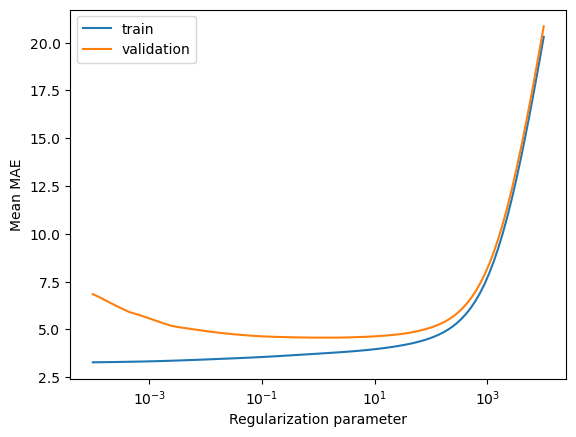

In [351]:
# Plot the MAE for different alpha values given the best performing parameters
ax = sns.lineplot(x=alpha_values, y=-best_model.cv_results_["mean_train_score"], label="train")
ax = sns.lineplot(x=alpha_values, y=-best_model.cv_results_["mean_test_score"], label="validation")
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean MAE")
plt.legend(loc="upper left")
plt.show()


Observation: the optimal regularisation parameter for the validation data set is in the range (0.1, 10).

R2: 0.999
MAE: 3.910
MSE: 36.325
#coef == 0: 0
#coef < 1e-10: 5


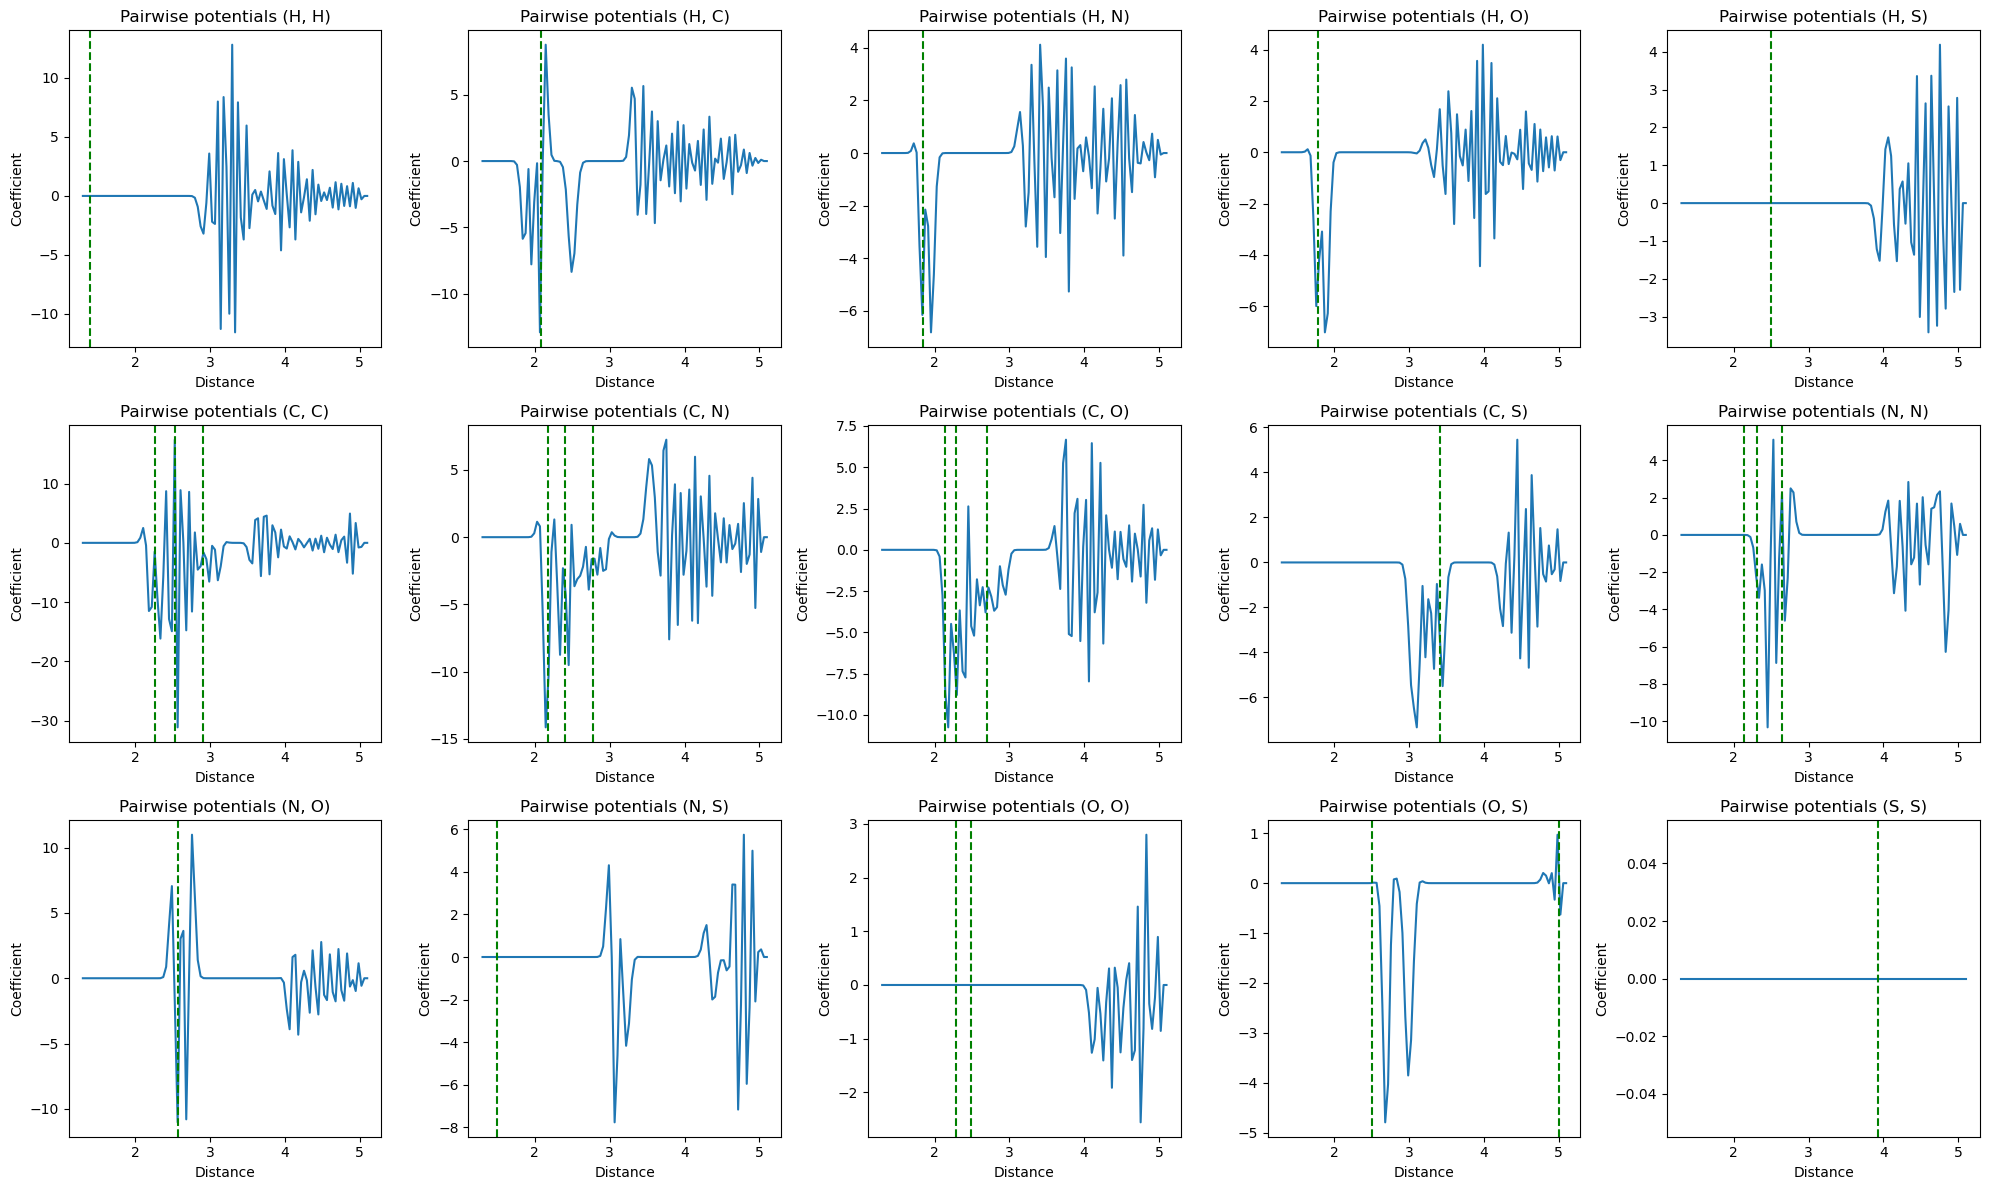

In [358]:
# Evaluate the model on the test set
recreate_and_score(best_model.best_estimator_, results[best_idx]["params"], shuffled_index)

# Plot the coefficients
plot_pp(best_model.best_estimator_, **results[best_idx]["params"])

Observation:
The resulting coefficients' plots suggest that even though our Ridge regression model is highly linear, it is strongly unregularised. This can be observed in the cyclic behaviour of the coefficients' plots.

In addition to that, due to the low SD, the unnatural discontinuities get introduced in the model and the effect of using a Gaussian function is practically invisible.

## For comparison: Ridge regression with the hard encoding (same parameters)

In [353]:
def represent_and_split_data(THETA_1, THETA_M, STD, M, soft=True):
    reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=soft)

    X_train, X_test, y_train, y_test = split_and_center(
        reps[shuffled_index],
        qm7["T"][0][shuffled_index],
        test_size=0.2,
        shuffle=False,
    )
    return X_train, X_test, y_train, y_test


R2: 0.912
MAE: 45.676
MSE: 4311.700
#coef == 0: 957
#coef < 1e-10: 1351


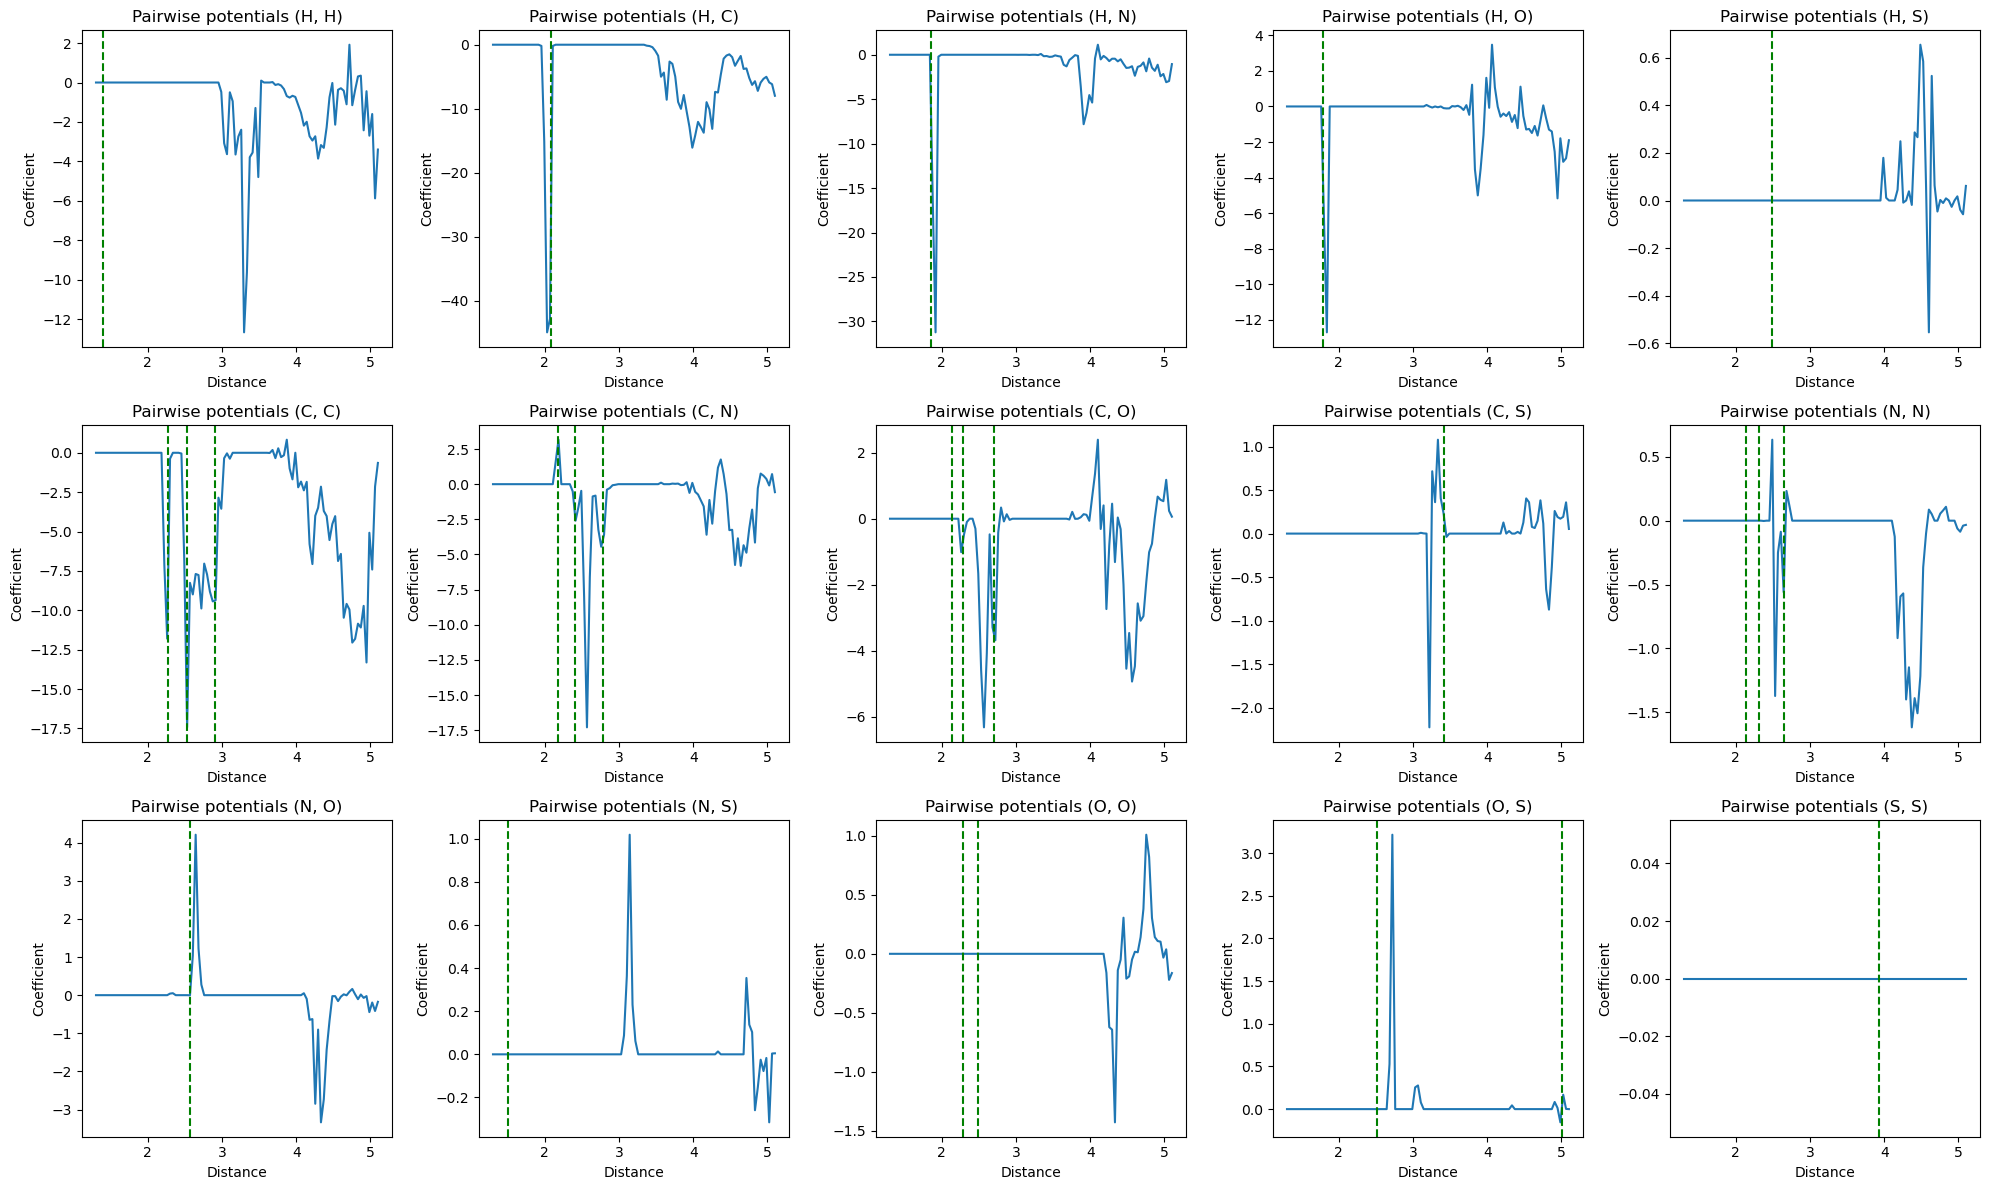

In [354]:
X_train, X_test, y_train, y_test = represent_and_split_data(**results[best_idx]["params"], soft=False)
fit_and_eval_model(Ridge(alpha=ALPHA, max_iter=10000), X_train, y_train, X_test, y_test, **results[best_idx]["params"])

Observation: the model performs similarly to the soft Ridge regression. That is because the previous model had a low regularisation term and low variance of the Gaussian function, making it effectively similar to the hard Ridge model seen here.

## For comparison: Multiple Linear Regression (soft encoding, same parameters)

For comparison reasons, we also computed a multiple linear regression which fits the data very poorly indicating that the regularisation in the Ridge regression, even if not very high, very strongly improved the model's predictions.

R2: -303320679590321024.000
MAE: 3278380669.941
MSE: 14915315058733718962176.000
#coef == 0: 76
#coef < 1e-10: 775


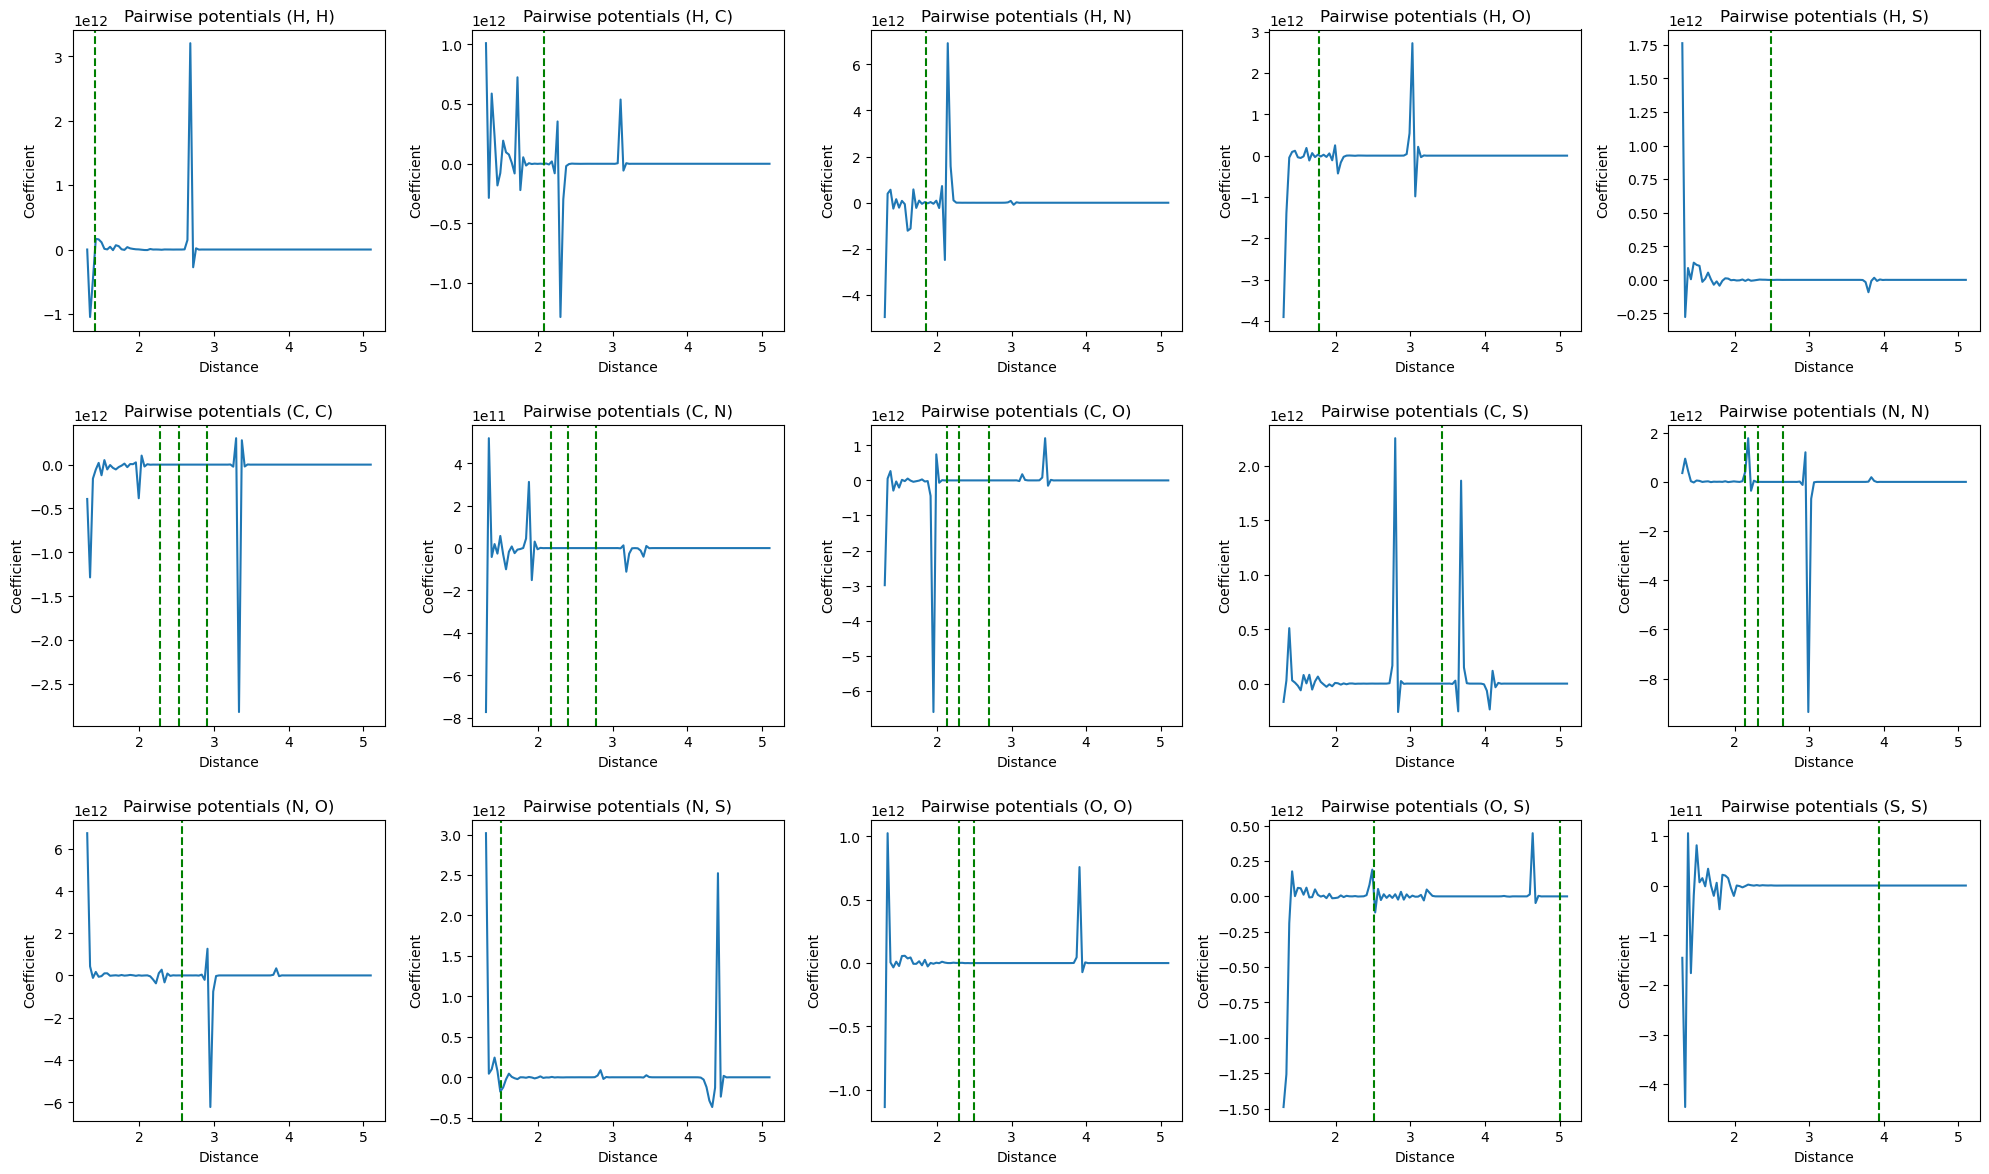

In [355]:
X_train, X_test, y_train, y_test = represent_and_split_data(**results[best_idx]["params"], soft=True)
fit_and_eval_model(LinearRegression(), X_train, y_train, X_test, y_test, **results[best_idx]["params"])

Observation: even though the selected penalty term in the Ridge regression is low, the Multiple linear regression is not able to capture the relationships in the data, and performs much worse in comparison.

# 3.2 Explanations: Pairs-of-atoms-based Data Representation

## Manual parameter search
## The best model in terms of explainability and external validity (soft encoding)

In order to achieve a better model, we first of all increased the SD to 0.1. This way the representation of the data is more smooth.
In addition to that, we increased the penalty term to 1000, to achieve a higher regularisation.
Both these changes should achieve a model with better explainability of the coefficients - due to smoothness and discarded cyclical behaviour.
Also, this way the external validity should be increased too, as the training data-specific behaviour is less pronounced.

R2: 0.996
MAE: 9.095
MSE: 207.298
#coef == 0: 128
#coef < 1e-10: 1352


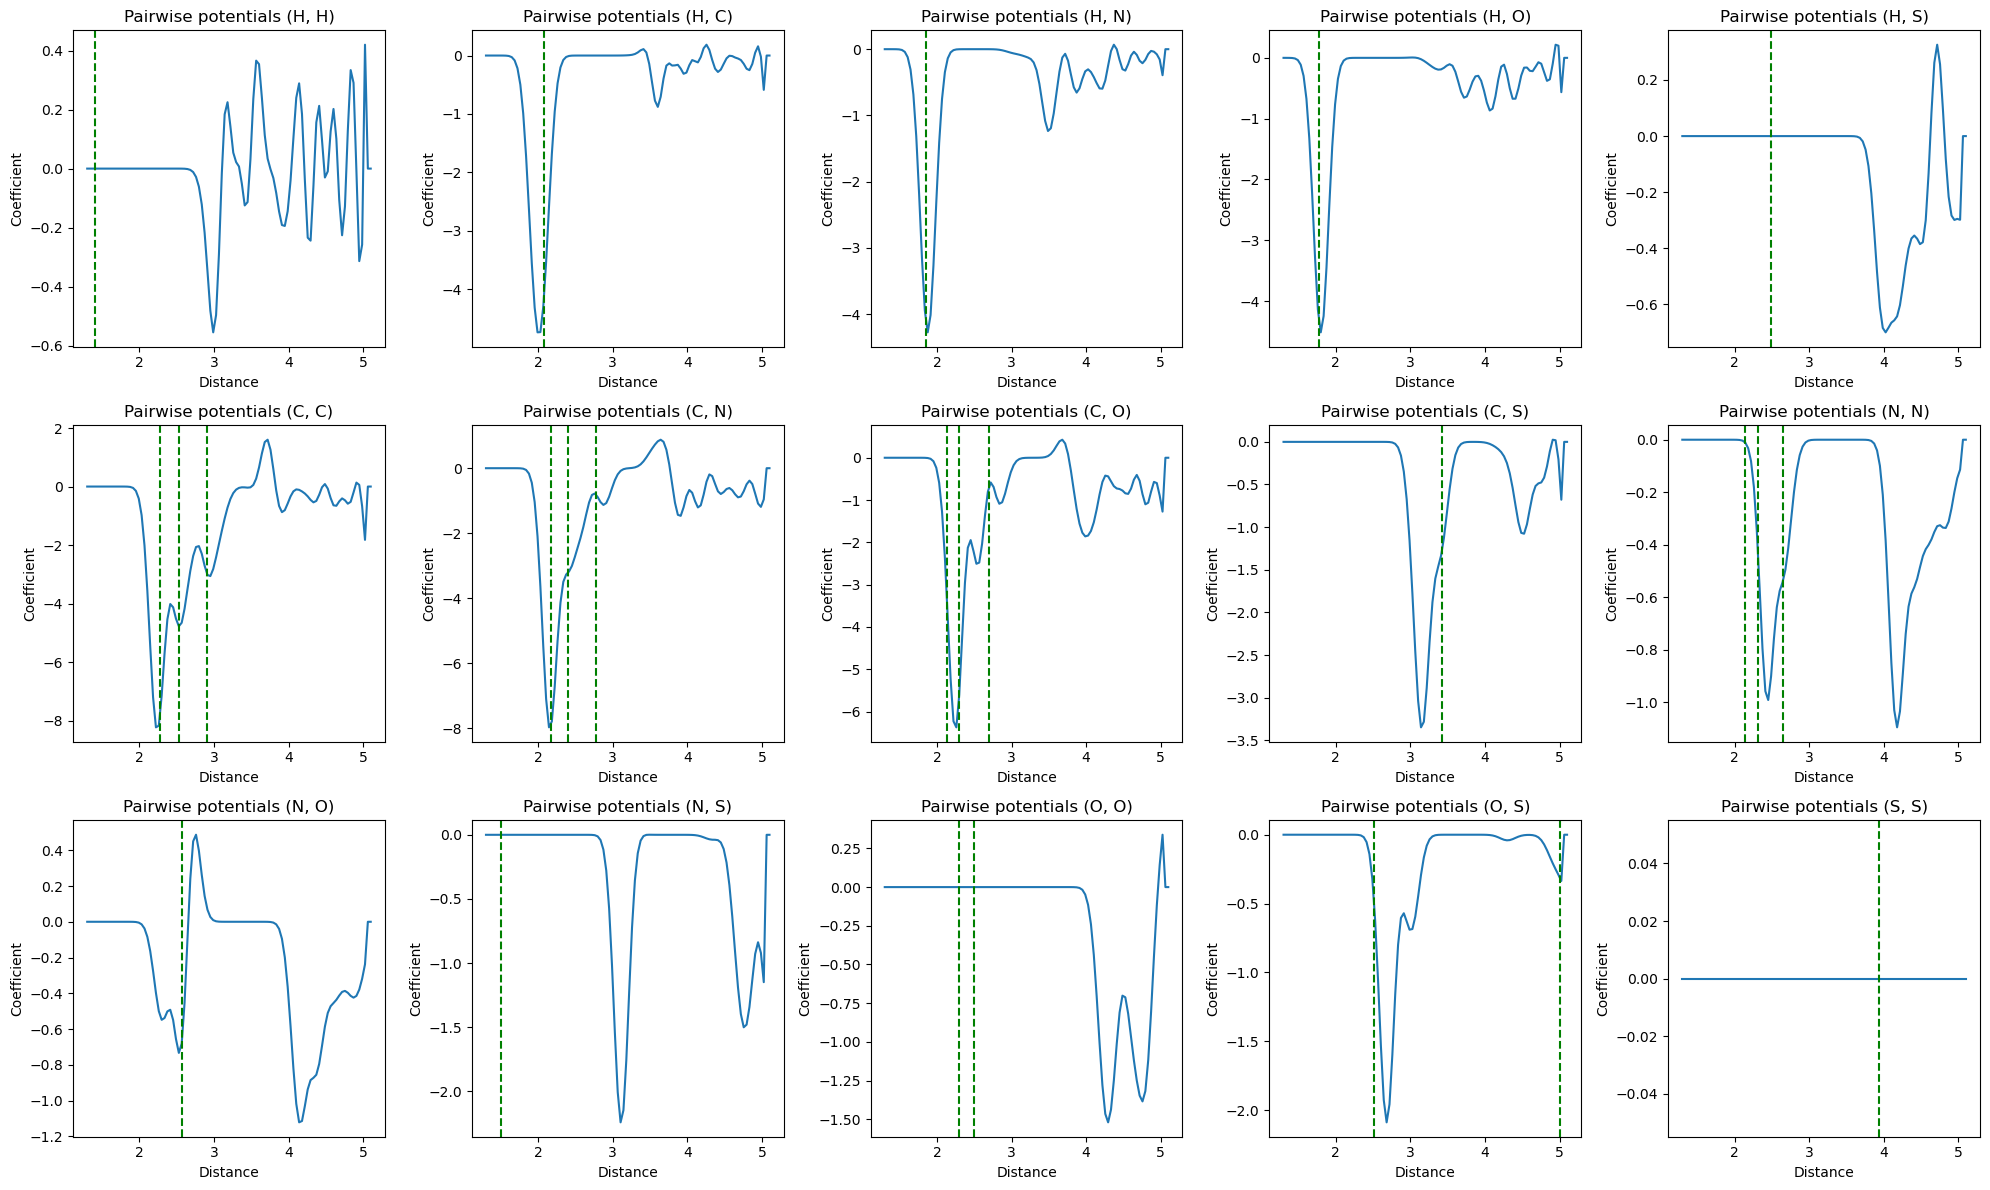

In [356]:
# Approach: look at the models where the # of coefficients higher than 1e-4 is minimal
# res_df.sort_values(by='n_coef_smaller_1e-4', ascending=False).head(20)

THETA_1 = 1.3
THETA_M = 5.1
M = 100
STD = 0.1

ALPHA = 1000

X_train, X_test, y_train, y_test = represent_and_split_data(THETA_1, THETA_M, STD, M, soft=True)
fit_and_eval_model(Ridge(alpha=ALPHA, max_iter=10000), X_train, y_train, X_test, y_test, M, THETA_1, THETA_M)


Observation:
The model achieves a somewhat higher MSE than the best performing model, but both the MSE and the explained variance are improved compared to the linear regression with a simple atom-based represenation.
In terms of our "sanity check", we can see that some coefficients represent the expected bond lengths very well (e.g. CC), while some of them do not (e.g. HH). Unfortunately, we can not explain the latter.
In the consultation we have learned that Ridge regression has an implicit non-local strategy: due to the penalty term it looks at distances that are farther away, but potentially overfits. It might be that some of the variation in the data is specific to our sample and not so representative of the population of the possible molecules.

In [357]:
# TODO verify purpose

# The purpose of using a ML approach is therefore not only to provide a computationally effective way of predicting the
# chemical relation of interest but also to identify what is needed in the molecular structure to be able to predict,
# and, using Explainable AI, what exact substructures are being used for prediction.
